In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns

We are start by exploring the data.
Main concerns:
-   if teams change leagues within our dataset
-   Use a moving average of corners scored

Mean of distribution of Corners: 10.21947125472094
Std of distribution of Corners: 3.451954759698488
Skew of distribution of Corners: 0.41437749668566753
Kurtosis of distribution of Corners: 0.25552111131914357


<AxesSubplot:xlabel='Total_Corners', ylabel='Probability'>

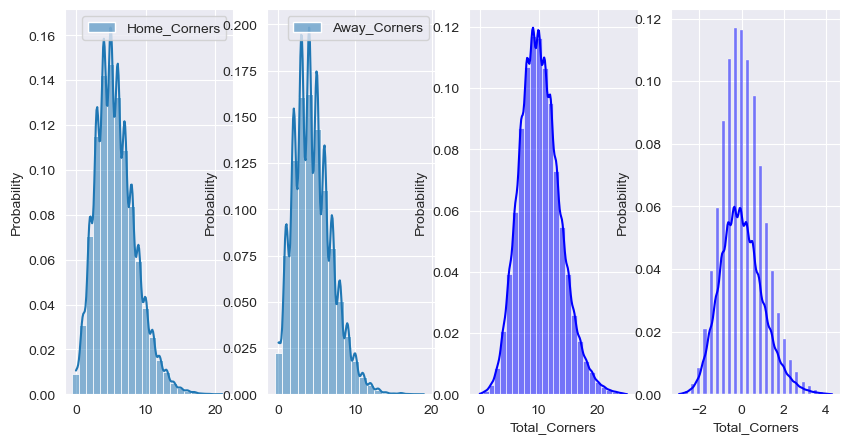

In [70]:
testSet = pd.read_csv("Data/test (15).csv")
trainSet = pd.read_csv("Data/train (15).csv")
trainSet["Date"] = pd.to_datetime(trainSet["Date"], dayfirst=True)
testSet["Date"] = pd.to_datetime(testSet["Date"], dayfirst=True)
trainSet["Total_Corners"] = trainSet["Home_Corners"]+trainSet["Away_Corners"]
trainSet.sort_values("Date", ascending=True, inplace=True)
trainSet.columns
testSet.drop('Unnamed: 8', axis=1, inplace=True)
fig, ax = plt.subplots(1,4, figsize=(10,5))
sns.histplot(trainSet[["Home_Corners"]], bins=50, ax=ax[0], kde=True, stat="probability", color="b", discrete=True)
sns.histplot(trainSet[["Away_Corners"]], bins=50, ax=ax[1], kde=True, stat="probability", color="b", discrete=True)
sns.histplot(trainSet["Total_Corners"], bins=50, ax=ax[2], kde=True, stat="probability", color="b", discrete=True)
print(f"Mean of distribution of Corners: {trainSet['Total_Corners'].mean()}")
print(f"Std of distribution of Corners: {trainSet['Total_Corners'].std()}")
print(f"Skew of distribution of Corners: {trainSet['Total_Corners'].skew()}")
print(f"Kurtosis of distribution of Corners: {trainSet['Total_Corners'].kurt()}")
sns.histplot((trainSet["Total_Corners"] - trainSet['Total_Corners'].mean())/trainSet['Total_Corners'].std(), bins=50, ax=ax[3], kde=True, stat="probability", color="b")
# trainSet

In [71]:
trainSet["MovingAverageHomeGoals"] = trainSet.groupby("HomeTeamId")["Home_Goals"].transform(lambda x : x.shift().rolling(window=5, min_periods=1).mean())
trainSet["MovingAverageAwayGoals"] = trainSet.groupby("AwayTeamId")["Away_Goals"].transform(lambda x : x.shift().rolling(window=5, min_periods=1).mean())
trainSet["MovingAverageHomeCorners"] = trainSet.groupby("HomeTeamId")["Home_Corners"].transform(lambda x : x.shift().rolling(window=5, min_periods=1).mean())
trainSet["MovingAverageAwayCorners"] = trainSet.groupby("AwayTeamId")["Away_Corners"].transform(lambda x : x.shift().rolling(window=5, min_periods=1).mean())

In [26]:
teams_with_multiple_leagues = trainSet.groupby('HomeTeamId')['LeagueId'].nunique()
teams_with_multiple_leagues = teams_with_multiple_leagues[teams_with_multiple_leagues > 1]
trainSet

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,MovingAverageHomeGoals,MovingAverageAwayGoals,MovingAverageHomeCorners,MovingAverageAwayCorners
0,2826,793,2005-04-02,410,908,2.0,0.0,15,1,NaN,NaN,15.0,1.0
31,3789,801,2005-04-02,758,434,1.0,1.0,6,4,NaN,NaN,6.0,4.0
30,3788,801,2005-04-02,489,599,2.0,0.0,3,5,NaN,NaN,3.0,5.0
29,3787,729,2005-04-02,912,445,3.0,3.0,5,2,NaN,NaN,5.0,2.0
28,3786,729,2005-04-02,1118,1237,5.0,0.0,4,4,NaN,NaN,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23821,307619,800,2010-12-18,5501,1279,2.0,2.0,3,5,1.8,1.0,5.0,2.4
23820,307618,800,2010-12-18,1028,3592,0.0,0.0,3,8,1.4,1.0,4.8,6.8
23819,307616,800,2010-12-18,4832,928,2.0,1.0,4,13,0.8,1.6,6.4,6.6
23823,307621,800,2010-12-18,473,1098,1.0,0.0,8,3,0.8,0.8,8.8,4.0


<AxesSubplot:>

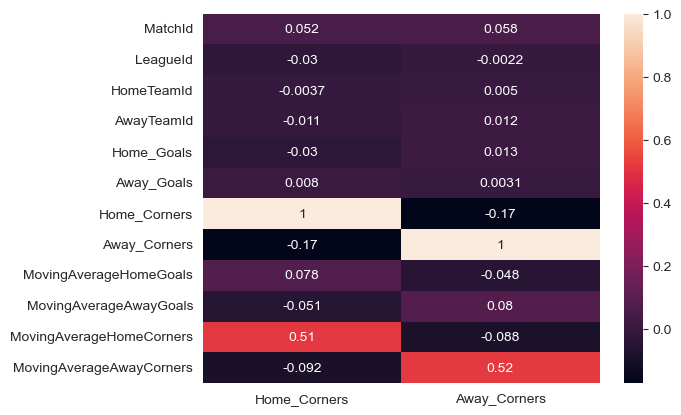

In [27]:
sns.heatmap(trainSet.corr()[["Home_Corners", "Away_Corners"]], annot=True)

In [54]:
# Estimation of the log normal distribution of the corners

10.5    77
9.5     60
11.5    27
Name: Line, dtype: int64